In [1]:
import pandas as pd
import os as os
import csv
import time

In [2]:
df = pd.read_csv("./datasets/canada.csv")

In [3]:
df

,text,disaster,gpe
0,Redcross is offering charitable donation recei...,"Relief, support",NaN
1,RT globeandmail Red Cross to transfer 50 milli...,NaN,Fort McMurray
2,Live Emergency operations briefing on north Al...,Emergency,Alberta
3,"9bn fire damage to Fort McMurray, the beast wi...","damage, fire",Fort McMurray
4,Labatt brewing water for Fort McMurray relief....,relief,Fort McMurray
...,...,...,...
333,RT Reggie Dunlop7 ItsRodStebbings Following Ro...,"Thoughts, support",NaN
334,Make sure you fill up and keep a full tank cau...,evacuation,NaN
335,James Taylor feels compelled to help AB wildfi...,"efforts, relief",NaN
336,I feel sad Mom amp; I r donating money to the ...,feel,NaN


In [4]:
import ollama
import re

def remove_before_think(text):
    return re.sub(r'^.*?</think>', '', text)

model = "deepseek-r1:1.5b"

def deepseek_response(prompt):
    response = ollama.chat(model=model, messages=[{"role": "user", "content": prompt}])
    content = response.message.content
    return re.sub(r'^.*?</think>\s*', '', content, flags=re.DOTALL)

In [5]:
df = df.dropna(subset=['gpe'])

In [6]:
df = df[:500]

In [7]:
df.to_csv("./datasets/canada.csv", index=False)

In [8]:
# Assume deepseek_response() is already defined
# def deepseek_response(text):
#     return "Some GPE response"  # Replace with actual LLM function

# CSV file path
csv_file = "./datasets/canada.csv"

# Read the existing CSV file
df = pd.read_csv(csv_file)

# Add new columns if not present
if "detected_gpe" not in df.columns:
    df["detected_gpe"] = ""
if "response_time" not in df.columns:
    df["response_time"] = ""

# Process each row and update detected_gpe and response_time
for index, row in df.iterrows():
    if pd.isna(row["detected_gpe"]) or row["detected_gpe"].strip() == "":
        text = row["text"]
        
        # Add instruction with a newline before the actual text
        prompt = f"Identify locations like country, city, or any local areas in the following sentence and write them in a comma-separated manner (no additional details required):\n\n{text}"
        
        start_time = time.time()  # Start timing
        detected_gpe = deepseek_response(prompt)  # Get LLM response
        end_time = time.time()  # End timing

        # Calculate response time
        response_time = round(end_time - start_time, 4)  # Rounded to 4 decimal places

        # Clean multiline response: strip spaces, join with commas if needed
        detected_gpe = ", ".join(line.strip() for line in detected_gpe.split("\n") if line.strip())

        # Update DataFrame
        df.at[index, "detected_gpe"] = detected_gpe
        df.at[index, "response_time"] = response_time

        # Save the updated row immediately to keep tracking progress
        df.to_csv(csv_file, index=False, quoting=csv.QUOTE_NONNUMERIC)

print("CSV file updated with detected GPE values and response times!")

CSV file updated with detected GPE values and response times!


In [9]:
df = pd.read_csv("./datasets/canada.csv")

In [10]:
df

,text,disaster,gpe,detected_gpe,response_time
0,RT globeandmail Red Cross to transfer 50 milli...,NaN,Fort McMurray,Fort McMurray,3.6836
1,Live Emergency operations briefing on north Al...,Emergency,Alberta,"north alberta, alberta",3.3356
2,"9bn fire damage to Fort McMurray, the beast wi...","damage, fire",Fort McMurray,"Canada, Fort McMurray, The Beast",4.7458
3,Labatt brewing water for Fort McMurray relief....,relief,Fort McMurray,"Canada, New York City, Fort McMurray",12.1374
4,RT marcmack Devastating wildfire in Fort McMur...,"destroyed, Devastating","Alberta, Fort McMurray","Fort McMurray, Alberta, Donado",3.6653
...,...,...,...,...,...
233,Fort McMurray Update Alberta fire officials sa...,fire,"Alberta, Fort McMurray, Alberta, Fort McMurray","Alberta, Fort McMurray",10.4277
234,How the Red Cross will spend funds collected y...,NaN,Fort McMurray,"The locations identified are ""Red Cross"" and ""...",4.7347
235,Conditions that must be met before Fort McMurr...,NaN,Fort McMurray,Fort McMurray,9.0302
236,RT RDFigs19 Weve created an auction to support...,support,Fort McMurray,"Fort McMurray, downtown Fort McMurray",8.1175


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           238 non-null    object 
 1   disaster       150 non-null    object 
 2   gpe            238 non-null    object 
 3   detected_gpe   238 non-null    object 
 4   response_time  238 non-null    float64
dtypes: float64(1), object(4)
memory usage: 9.4+ KB


In [12]:
import tiktoken  # Ensure tiktoken is installed

# Assume deepseek_response() is already defined
# def deepseek_response(text):
#     return "Some GPE response"  # Replace with actual LLM function

# Load tokenizer (using OpenAI's tokenizer as an example)
tokenizer = tiktoken.get_encoding("cl100k_base")  # Update if using another tokenizer


# Add new columns if not present
for col in ["query_tokens", "response_tokens"]:
    if col not in df.columns:
        df[col] = ""

# Process each row and update detected_gpe, response_time, and token counts
for index, row in df.iterrows():
    text = row["text"]
    detected_gpe = row["detected_gpe"]
    prompt = f"Identify locations like country, city, or any local areas in the following sentence and write them in a comma-separated manner (no additional details required):\n\n{text}"
    # Token count using DeepSeek's tokenizer
    query_tokens = len(tokenizer.encode(prompt))
    response_tokens = len(tokenizer.encode(detected_gpe))

    df.at[index, "query_tokens"] = query_tokens
    df.at[index, "response_tokens"] = response_tokens

    # Save the updated row immediately to keep tracking progress
    df.to_csv(csv_file, index=False, quoting=csv.QUOTE_NONNUMERIC)

print("CSV file updated with detected GPE values, response times, and token counts!")


CSV file updated with detected GPE values, response times, and token counts!


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             238 non-null    object 
 1   disaster         150 non-null    object 
 2   gpe              238 non-null    object 
 3   detected_gpe     238 non-null    object 
 4   response_time    238 non-null    float64
 5   query_tokens     238 non-null    object 
 6   response_tokens  238 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.1+ KB


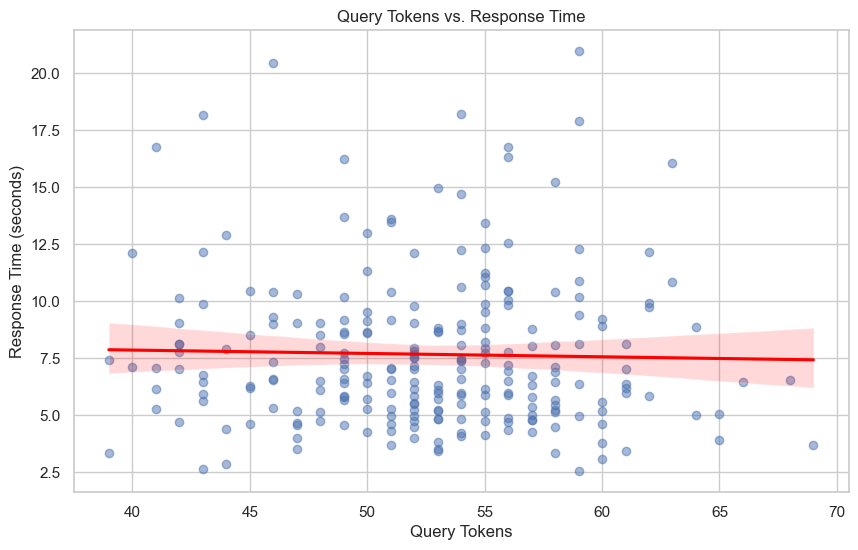

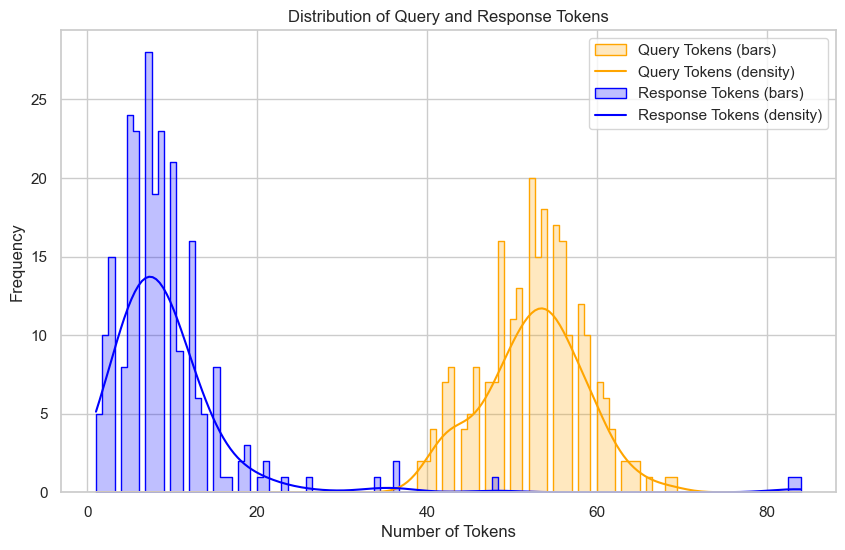

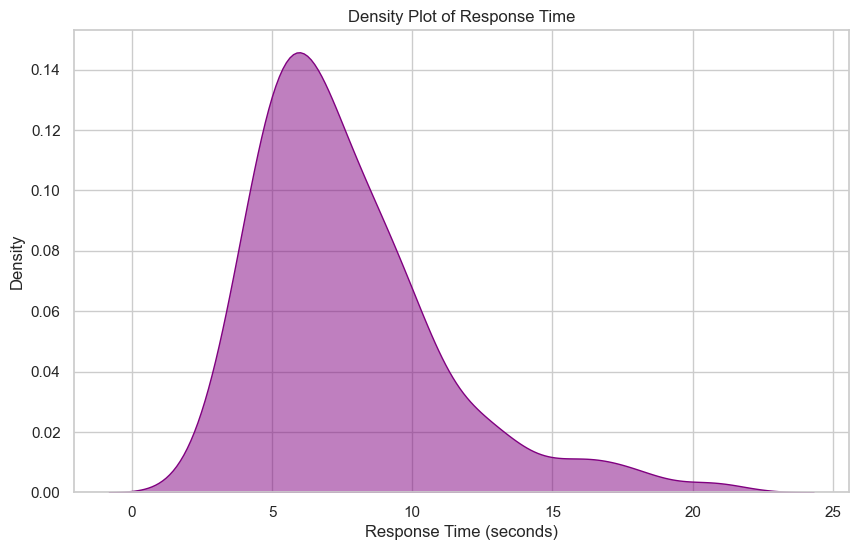

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV file path
csv_file = "./datasets/canada.csv"

# Read the CSV file
df = pd.read_csv(csv_file)

# Convert columns to numeric (in case they were mistakenly read as object)
df["query_tokens"] = pd.to_numeric(df["query_tokens"], errors="coerce")
df["response_tokens"] = pd.to_numeric(df["response_tokens"], errors="coerce")
df["response_time"] = pd.to_numeric(df["response_time"], errors="coerce")

# Set plot style
sns.set_theme(style="whitegrid")

# Figure 1: Scatter Plot (Query Tokens vs. Response Time)
plt.figure(figsize=(10, 6))
sns.regplot(x=df["query_tokens"], y=df["response_time"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Query Tokens")
plt.ylabel("Response Time (seconds)")
plt.title("Query Tokens vs. Response Time")
plt.show()

# Figure 2: Bar Chart (Query Tokens vs. Response Tokens)
plt.figure(figsize=(10, 6))
sns.histplot(df[["response_tokens", "query_tokens"]], bins=114, kde=True, element="step", palette=["blue", "orange"])
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Distribution of Query and Response Tokens")
plt.legend(["Query Tokens (bars)", "Query Tokens (density)","Response Tokens (bars)", "Response Tokens (density)"])
plt.show()

# Figure 3: Density Plot (Response Time Distribution)
plt.figure(figsize=(10, 6))
sns.kdeplot(df["response_time"], fill=True, color="purple", alpha=0.5)
plt.xlabel("Response Time (seconds)")
plt.ylabel("Density")
plt.title("Density Plot of Response Time")
plt.show()


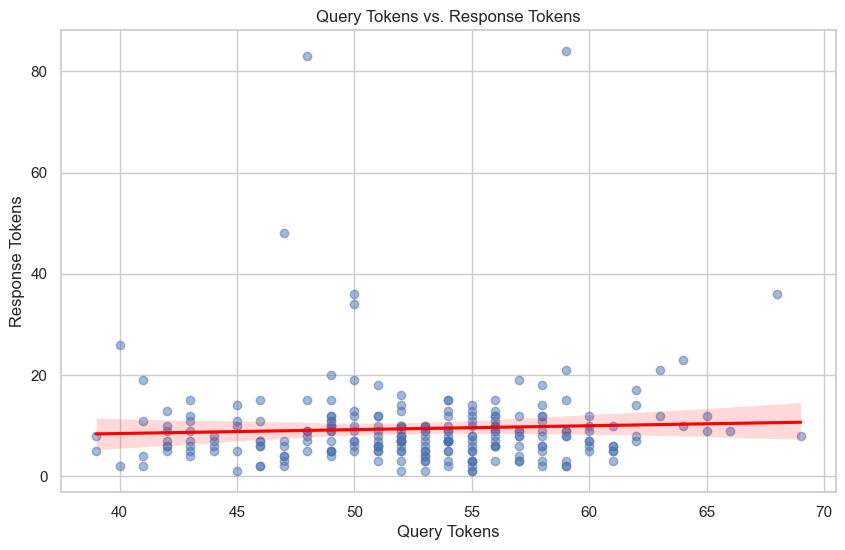

In [15]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df["query_tokens"], y=df["response_tokens"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Query Tokens")
plt.ylabel("Response Tokens")
plt.title("Query Tokens vs. Response Tokens")
plt.show()

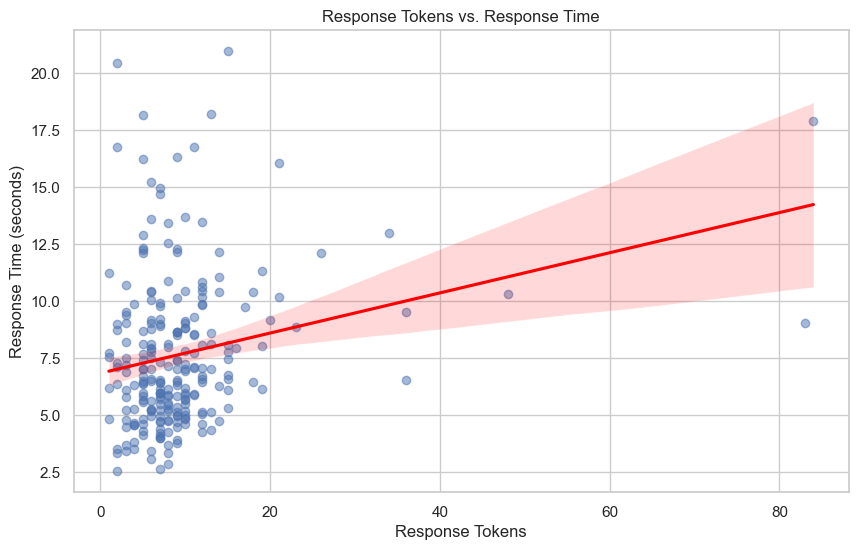

In [16]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df["response_tokens"], y=df["response_time"], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Response Tokens")
plt.ylabel("Response Time (seconds)")
plt.title("Response Tokens vs. Response Time")
plt.show()

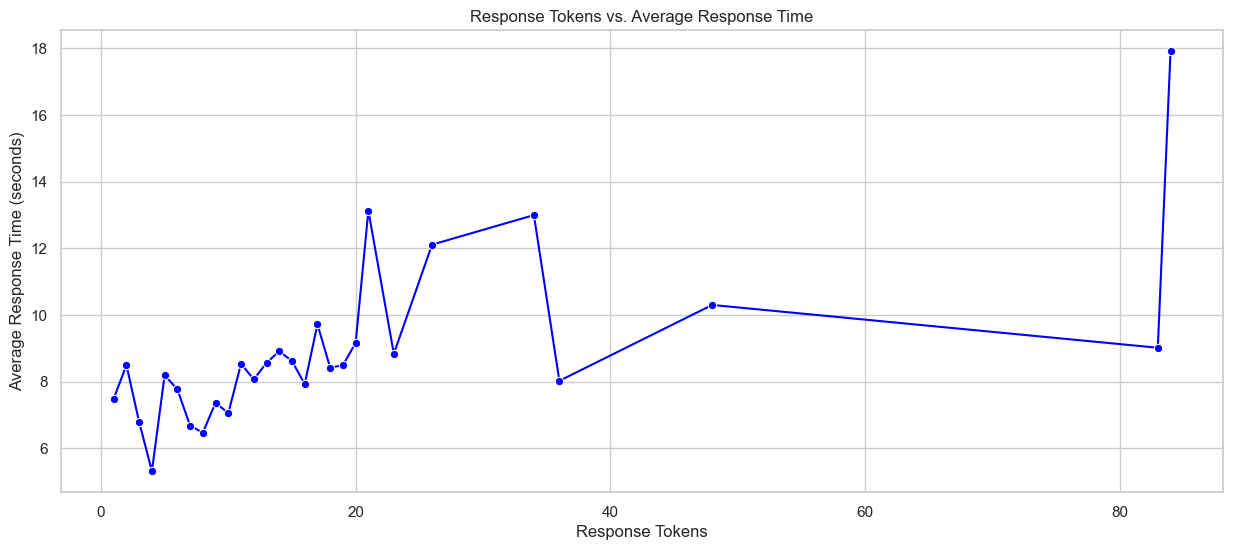

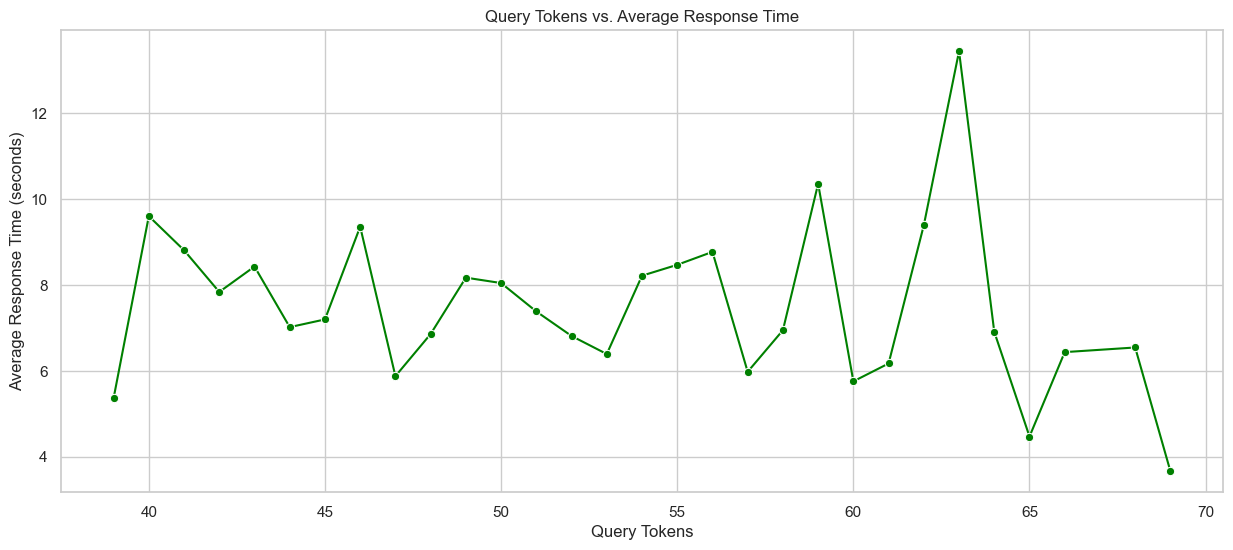

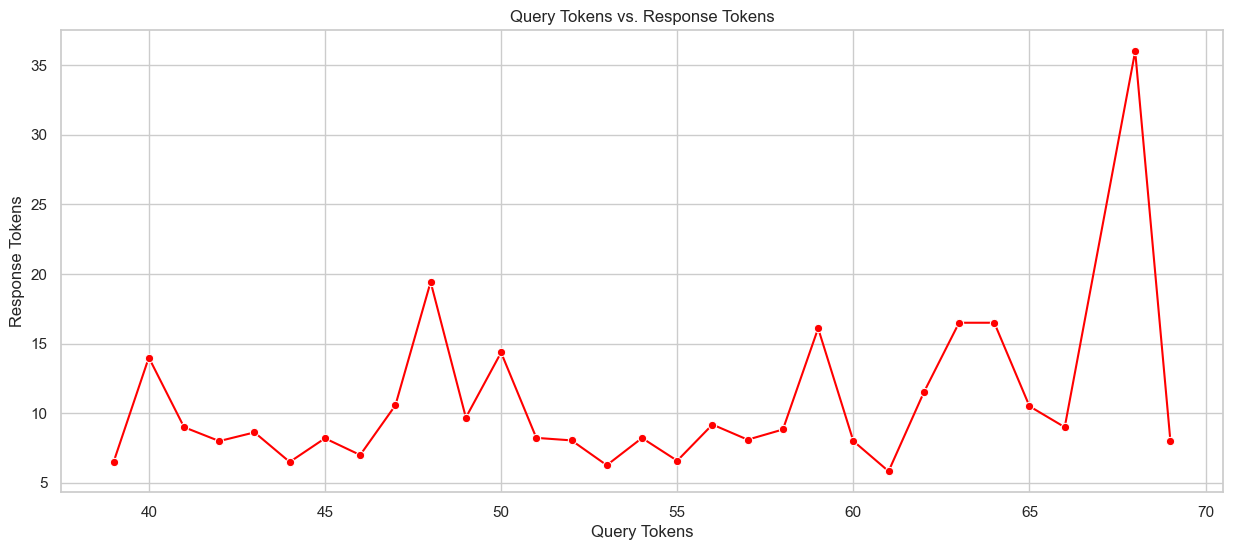

In [17]:
avg_response_time_r = df.groupby("response_tokens")["response_time"].mean().reset_index()
avg_response_time_q = df.groupby("query_tokens")["response_time"].mean().reset_index()
avg_response_tokens = df.groupby("query_tokens")["response_tokens"].mean().reset_index()
# Set plot style
sns.set_theme(style="whitegrid")

# Plot: Response Tokens vs. Average Response Time
plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_time_r["response_tokens"], y=avg_response_time_r["response_time"], marker="o", color="blue")
plt.xlabel("Response Tokens")
plt.ylabel("Average Response Time (seconds)")
plt.title("Response Tokens vs. Average Response Time")
plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_time_q["query_tokens"], y=avg_response_time_q["response_time"], marker="o", color="green")
plt.xlabel("Query Tokens")
plt.ylabel("Average Response Time (seconds)")
plt.title("Query Tokens vs. Average Response Time")
plt.show()

plt.figure(figsize=(15, 6))
sns.lineplot(x=avg_response_tokens["query_tokens"], y=avg_response_tokens["response_tokens"], marker="o", color="red")
plt.xlabel("Query Tokens")
plt.ylabel("Response Tokens")
plt.title("Query Tokens vs. Response Tokens")
plt.show()

In [18]:
df

,text,disaster,gpe,detected_gpe,response_time,query_tokens,response_tokens
0,RT globeandmail Red Cross to transfer 50 milli...,NaN,Fort McMurray,Fort McMurray,3.6836,51,3
1,Live Emergency operations briefing on north Al...,Emergency,Alberta,"north alberta, alberta",3.3356,39,8
2,"9bn fire damage to Fort McMurray, the beast wi...","damage, fire",Fort McMurray,"Canada, Fort McMurray, The Beast",4.7458,55,8
3,Labatt brewing water for Fort McMurray relief....,relief,Fort McMurray,"Canada, New York City, Fort McMurray",12.1374,43,9
4,RT marcmack Devastating wildfire in Fort McMur...,"destroyed, Devastating","Alberta, Fort McMurray","Fort McMurray, Alberta, Donado",3.6653,69,8
...,...,...,...,...,...,...,...
233,Fort McMurray Update Alberta fire officials sa...,fire,"Alberta, Fort McMurray, Alberta, Fort McMurray","Alberta, Fort McMurray",10.4277,56,6
234,How the Red Cross will spend funds collected y...,NaN,Fort McMurray,"The locations identified are ""Red Cross"" and ""...",4.7347,52,14
235,Conditions that must be met before Fort McMurr...,NaN,Fort McMurray,Fort McMurray,9.0302,47,3
236,RT RDFigs19 Weve created an auction to support...,support,Fort McMurray,"Fort McMurray, downtown Fort McMurray",8.1175,59,8
